#  Лабораторная работа 2
##  Кознев Никита (Вариант 8)

### РЕШЕНИЕ КРАЕВЫХ ЗАДАЧ. МЕТОДЫ КОЛЛОКАЦИЙ, НАИМЕНЬШИХ КВАДРАТОВ И ГАЛЕРКИНА

### Цель:

+ изучить методы коллокаций, наименьших квадратов и Галеркина, составить алгоритмы методов и программы их реализаций, получить численное решение заданной краевой задачи;

+ составить алгоритм решения краевых задач указанными методами, применимыми для организации вычислений  на ПЭВМ;

+ составить программу решения краевых задач по разработанным алгоритмам;

+ выполнить тестовые примеры и проверить правильность работы программ.

### Задание

Методами коллокаций, интегральным и дискретным методами наименьших квадратов и Галеркина получить численное решение краевой задачи

y′′ + (1 + x^2)*y = −1,
− 1 ≤ x ≤ 1;

ay′′ + (1 + bx^2)*y = −1,
− 1 ≤ x ≤ 1.

### Исходные данные:

a = sin(k), b = cos(k), где k = 8. 
Базисную систему выбрать в виде
i = 1, 2,... .
φ(i)(x) = x(i)(1 − x),
φ(0) = 0,

In [1]:
%matplotlib inline
import numpy
import math
import matplotlib
import random
from scipy.misc import derivative
from scipy import integrate
matplotlib.rc('figure', figsize=(12, 8))

In [2]:
def basis_f(n: int, der: int=0):
    # x^i(1-x^2) = x^i-x^i+2
    f = lambda x: x**n - x**(n + 2)
    if der == 0:
        def _bf(x: float):
            return x**n - x**(n+2)
        return _bf
    if der > 0:
        def _bf(x: float):
            return derivative(f, x, n=der, dx=1e-3)
        return _bf

In [3]:
def get_colloc_system(n, a, b, p, q, f):
    res = numpy.zeros((n, n))
    free_mem = numpy.zeros((n,))
    colloc_points = numpy.linspace(a, b, num=n)
    for i in range(n):
        x = colloc_points[i]
        free_mem[i] = f(x)
        for j in range(n):
            res[i][j] = basis_f(j, der=2)(x) + p(x) * basis_f(j, der=1)(x) + q(x) * basis_f(j)(x)
    return res, free_mem

In [4]:
def collocations_method(a, b, n, p, q, f):
    coeffs = numpy.linalg.solve(*get_colloc_system(n, a, b, p, q, f))
    def _f(x):
        res = 0
        for i, a in enumerate(coeffs):
            res += basis_f(i)(x) * a
        return res
    return _f

1.28 s ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


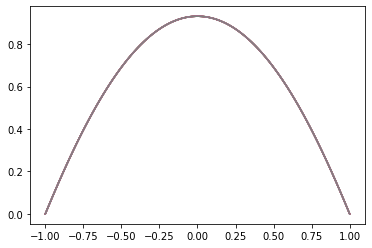

In [5]:
%%timeit
p = lambda x: 0
q = lambda x: 1 + x**2
f = lambda x: -1
y1 = collocations_method(-1, 1, 100, p, q, f)
points = numpy.linspace(-1, 1, 100)
matplotlib.pyplot.plot(points, [y1(x) for x in points])

1.32 s ± 26.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


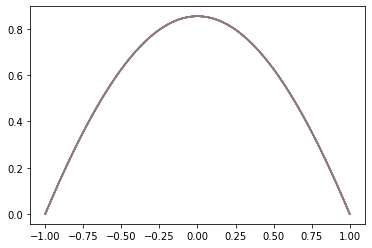

In [7]:
%%timeit
k = 8
p = lambda x: 0
q = lambda x: (1 + math.cos(k) * x**2) / math.sin(k)
f = lambda x: -1 / math.sin(k)
y1 = collocations_method(-1, 1, 100, p, q, f)
points = numpy.linspace(-1, 1, 100)
matplotlib.pyplot.plot(points, [y1(x) for x in points])

In [8]:
def get_lsm_system(n, a, b, p, q, f):
    res = numpy.zeros((n, n))
    free_mem = numpy.zeros((n,))
    points = numpy.linspace(a, b, num=n)
    dx = (b - a) / n
    basis = numpy.zeros((n, 3, n))
    f_map = numpy.array([f(x) for x in points])
    p_map = numpy.array([p(x) for x in points])
    q_map = numpy.array([q(x) for x in points])
    for i in range(n):
        basis[i][0] = numpy.array(list(map(basis_f(i), points)))
        basis[i][1] = numpy.array(list(map(basis_f(i, der=1), points)))
        basis[i][2] = numpy.array(list(map(basis_f(i, der=2), points)))        
    for i in range(n):
        multiplier = basis[i][2] + p_map * basis[i][1] + q_map * basis[i][0]
        free_mem[i] = 2 * numpy.trapz(f_map * multiplier, dx=dx)
        for j in range(n):
            res[i][j] = 2 * numpy.trapz((basis[j][2] + p_map * basis[j][1] + q_map * basis[j][0]) * multiplier, dx=dx)
    return res, free_mem

In [9]:
def lsm(a, b, n, p, q, f):
    coeffs = numpy.linalg.solve(*get_lsm_system(n, a, b, p, q, f))
    def _f(x):
        res = 0
        for i, a in enumerate(coeffs):
            res += basis_f(i)(x) * a
        return res
    return _f

1.86 s ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


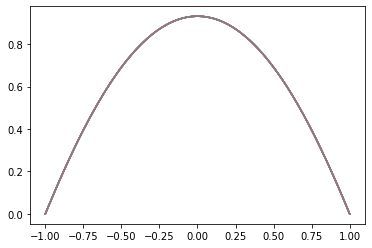

In [10]:
%%timeit
p = lambda x: 0
q = lambda x: 1 + x**2
f = lambda x: -1
y1 = lsm(-1, 1, 100, p, q, f)
points = numpy.linspace(-1, 1, 100)
matplotlib.pyplot.plot(points, [y1(x) for x in points])

1.85 s ± 151 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


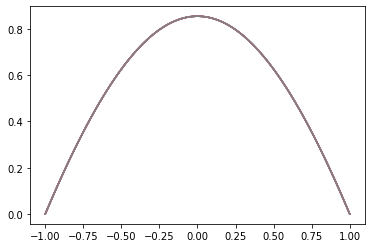

In [16]:
%%timeit
# y" + p(x)y' + q(x)y = f(x)
k = 8
p = lambda x: 0
q = lambda x: (1 + math.cos(k) * x**2) / math.sin(k)
f = lambda x: -1 / math.sin(k)
y1 = lsm(-1, 1, 100, p, q, f)
points = numpy.linspace(-1, 1, 100)
matplotlib.pyplot.plot(points, [y1(x) for x in points])    


In [12]:
def get_galerkin_system(n, a, b, p, q, f):
    res = numpy.zeros((n, n))
    free_mem = numpy.zeros((n,))
    points = numpy.linspace(a, b, num=n)
    dx = (b - a) / n
    basis = numpy.zeros((n, 3, n))
    f_map = numpy.array([f(x) for x in points])
    p_map = numpy.array([p(x) for x in points])
    q_map = numpy.array([q(x) for x in points])
    for i in range(n):
        basis[i][0] = numpy.array(list(map(basis_f(i), points)))
        basis[i][1] = numpy.array(list(map(basis_f(i, der=1), points)))
        basis[i][2] = numpy.array(list(map(basis_f(i, der=2), points)))                                             
    for i in range(n):
        free_mem[i] = numpy.trapz(f_map * basis[i][0], dx=dx)
        for j in range(n):
            res[i][j] = numpy.trapz((basis[j][2] + p_map * basis[j][1] + q_map * basis[j][0]) * basis[i][0], dx=dx)
    return res, free_mem

In [13]:
def galerkin_method(a, b, n, p, q, f):
    coeffs = numpy.linalg.solve(*get_galerkin_system(n, a, b, p, q, f))
    def _f(x):
        res = 0
        for i, a in enumerate(coeffs):
            res += basis_f(i)(x) * a
        return res
    return _f

1.85 s ± 190 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


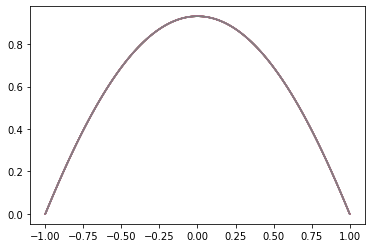

In [14]:
%%timeit
p = lambda x: 0
q = lambda x: 1 + x**2
f = lambda x: -1

y1 = galerkin_method(-1, 1, 100, p, q, f)
points = numpy.linspace(-1, 1, 100)
matplotlib.pyplot.plot(points, [y1(x) for x in points])

1.81 s ± 149 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


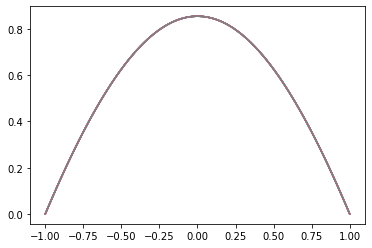

In [15]:
%%timeit
k = 8
p = lambda x: 0
q = lambda x: (1 + math.cos(k) * x**2) / math.sin(k)
f = lambda x: -1 / math.sin(k)
y1 = galerkin_method(-1, 1, 100, p, q, f)
points = numpy.linspace(-1, 1, 100)
matplotlib.pyplot.plot(points, [y1(x) for x in points]) 